<h1>CS4618: Artificial Intelligence I</h1>
<h1>Logistic Regression</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from math import exp, log

In [3]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "." 

<h1>Logistic Regression</h1>
<ul>
    <li>In the previous two lectures, we 'opened up the black box', and found exactly how OLS regresssion works. We learned two ways of finding the values $\v{\beta}$.</li>
    <li>Now, let's do the same for classification.</li>
    <li>Despite its name, <b>logistic regression</b> is used for <em>classification</em>.
        <ul>
            <li>At heart, it predicts a number (and turns it into a probability), and perhaps this is why its name
                mentions regression.
            </li>
            <li>At heart, it builds linear models.</li>
        </ul>
    </li>
</ul>

<h1>Logistic Regression for Binary Classification</h1>
<ul>
 <li>Let's start with logistic regression for <b>binary classification</b>.
        <ul>
            <li>In this case, logistic regression predicts the probability that $\v{x}$ belongs to
                the positive class.
            </li>
        </ul>
    </li>
    <li>This is what logistic regression does:
    $$\hat{y} = \left\{ \begin{array}{rl} 
        0 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) <  0.5 \\
        1 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) \geq 0.5
                        \end{array} \right.
    $$
    where
    $$Prob(\hat{y} = 1\, |\, \v{x}) = \sigma(\v{x}\v{\beta})$$
    where
    $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
    and 
    $\v{x}\v{\beta}$
    is familiar from linear regression (and assumes that $\v{x}$ has an extra 'feature',
    $x_0 = 1$)
    </li>
    <li>We'll study this bit by bit.</li>
</ul>

<h2>We Can't Just Use Linear Regression</h2>
<ul>
    <li>In Linear Regression, each hypothesis $h_{\v{\beta}}$ was of the form 
        $$\begin{array}{rl}
            h_{\v{x}}(\v{\beta}) & = \v{\beta}_0 + \v{\beta}_1\v{x}_1 + \v{\beta}_2\v{x}_2 + \ldots + \v{\beta}_n\v{x}_n \\
                                 & = \v{x}\v{\beta}
          \end{array}
    $$
        where $\v{x}$ is a row vector with $n+1$ elements (with $\v{x}_0 = 1$), and $\v{\beta}$ is a (column)
        vector of coefficients
    </li>
    <li>Why can't we just use this directly to predict probabilities?
        <ul>
            <li>To help you answer, here is one hypothesis $h_{\v{\beta}}$ for the CS1109 dataset
                (using just one of its features, $\mathit{lab}$, for easy visualization).
            </li>
        </ul>
    </li>
</ul>

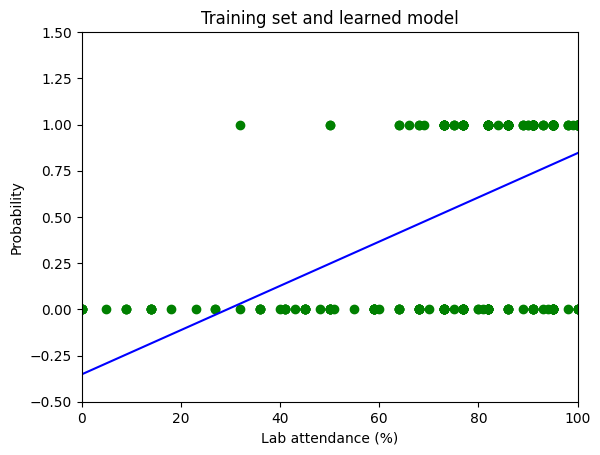

In [4]:
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_cs1109.csv"))

X = df[["lab"]].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["outcome"])

linreg = LinearRegression()
linreg.fit(X, y)

xvals = np.array([[0], [100]])
yvals = linreg.predict(xvals)

fig = plt.figure()
plt.title("Training set and learned model")
plt.scatter(X, y, color = "green")
plt.plot(xvals, yvals, color = "blue")
plt.xlabel("Lab attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Probability")
plt.ylim(-0.5, 1.5)
plt.show()

<h2>The Logistic Function</h2>
<ul>
    <li>To 'squash' the values of $\v{x}{\v{\beta}}$ to $[0,1]$ so we can treat them as
        probabilities:
        $$h_{\v{\beta}} = \sigma(\v{x}{\v{\beta}})$$
        where $\sigma$ is the <b>logistic function</b> (also called the 'logit'):
        $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
    </li>
    <li>The logistic function is also caled the  <b>sigmoid function</b> (which is what we will call it)
        because it is S-shaped:
    </li>
</ul>

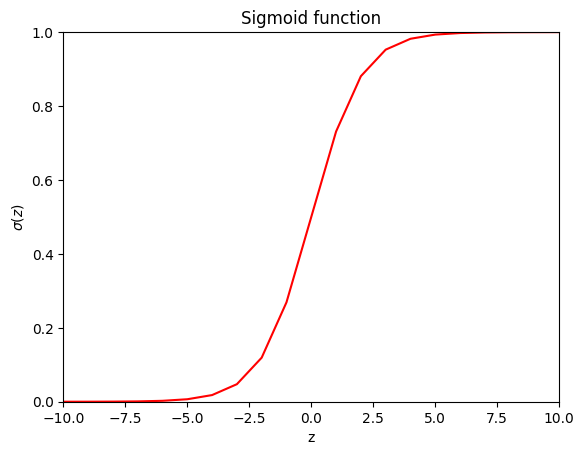

In [5]:
def sigma(z):
    return 1 / (1 + exp(-z))

fig = plt.figure()
plt.title("Sigmoid function")
xvals = np.linspace(-10, 10, 21)
plt.plot(xvals, [sigma(xval) for xval in xvals], color = "red")
plt.xlabel("z")
plt.xlim(-10, 10)
plt.ylabel(r"$\sigma(z)$")
plt.ylim(0.0, 1.0)
plt.show()

<ul>
    <li>A minor point: the sigmoid function asymptotically approaches 0 and 1.
        <ul>
            <li>So, in fact its values are in $(0,1)$ and not $[0,1]$.</li>
        </ul>
    </li>
</ul>

<h2>Thresholding</h2>
<ul>
    <li>The hypotheses that logistic regression learns, 
        $h_{\v{\beta}} = \sigma(\v{x}\v{\beta})$, output numbers between 0 and 1.
    </li>
    <li>We interpret these numbers as probabilities: the probability that $\v{x}$ belongs to the positive class
        $$Prob(\hat{y} = 1\, |\, \v{x}) = \sigma(\v{x}\v{\beta})$$
    </li>
    <li>Then, to make this a classifier (so it outputs one of the two class labels), we threshold:
        $$\hat{y} = \left\{
           \begin{array}{rl}
           0 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) < 0.5 \\
           1 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) \geq 0.5
           \end{array} \right.
        $$
    </li>
</ul>

<h2>Decision Boundary</h2>
<ul>
    <li>The examples for which logistic regression predicts probabilities of 0.5,
        $Prob(\hat{y} = 1\, |\, \v{x}) = 0.5)$, lie on what is called the <b>decision boundary</b>.
    </li>
    <li>If you look back at the graph of the sigmoid function, its output is 0.5 when its
        input ($z$) is zero.
    </li>
    <li>It follows that the decision boundary are examples where
        $$\v{x}{\v{\beta}} = 0$$
    </li>
</ul>

<h2>Example</h2>
<ul>
    <li>Suppose our hypothesis is $\beta = \cv{3200\\-40\\-40\\0}$.
    </li>
    <li>I.e. $Prob(\hat{\v{y}} = 1\, |\, \v{x}) = 
        \sigma(3200 - 40\times\mathit{lect} - 40\times\mathit{lab} + 0 \times\mathit{cao})$
    </li>
    <li>So what does this model predict for Craig, who attended 60% of lectures, 25% of labs and has 500 
        CAO points, $\v{x} = \rv{1, 60, 25, 500}$?
        <ul>
            <li>Compute $\v{x}\v{\beta}$: $\rv{1, 60, 25, 500}\cv{3200\\-40\\-40\\0} = -200$</li>
            <li>Compute sigmoid: $\sigma(-200) = \frac{1}{1 + e^{\,-\,-200}} = 1.38 \times 10^{-87}$
                <ul>
                    <li>This is the probability that Craig belongs to the positive class.</li>
                </ul>
            </li>
            <li>Threshold: Since $1.38 \times 10^{-87} < 0.5$, this model predicts that Craig does belong
                to the positive class.
            </li>
        </ul>
    </li>
    <li>And we can plot the decision boundary for this model 
        ($3200 - 40\times\mathit{lect} - 40\times\mathit{lab} + 0 \times\mathit{cao} = 0$):
    </li>
</ul>

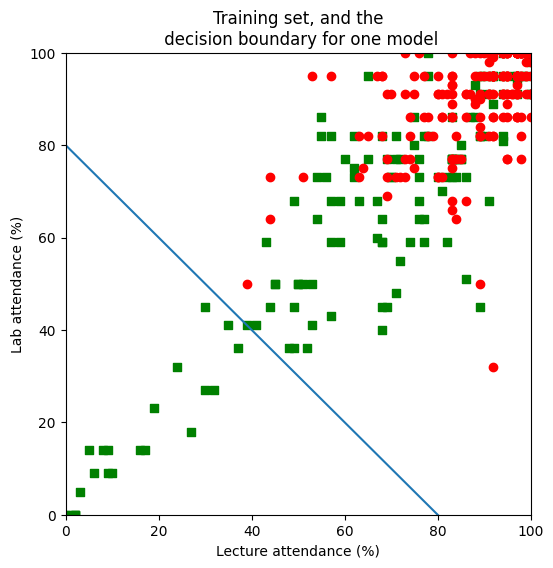

In [6]:
lects = df["lect"]
labs = df["lab"]
outcomes = df["outcome"]

fig = plt.figure(figsize=(6,6))
plt.title("Training set, and the\n decision boundary for one model")
plt.scatter(lects[outcomes=="fail"], labs[outcomes=="fail"], color = "green", marker="s")
plt.scatter(lects[outcomes=="pass"], labs[outcomes=="pass"], color = "red", marker="o")
xvals = np.linspace(0, 100, 2)
plt.plot(xvals, 80 - xvals)
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Lab attendance (%)")
plt.ylim(0, 100)
plt.show()

<ul>
    <li>What's your opinion of this model?</li>
</ul>

<h2>The Loss Function</h2>
<ul>
    <li>The logistic regression learning algorithm will take a labeled dataset and try to find good values
        for $\v{\beta}$.
    </li>
    <li>It needs a loss function, which penalizes $h_{\v{\beta}}$ if 
        <ul>
            <li>it outputs high probabilities for negative examples; and</li>
            <li>it outputs low probabilities for positive examples.</li>
        </ul>
    </li>
    <Li>The loss function that we will use is based around logarithms.</li>
    <li>Let's see why logs are useful for defining a loss function.
    </li>
</ul>

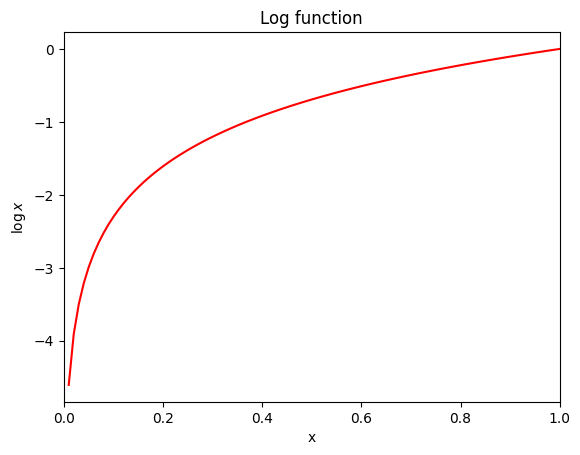

In [7]:
fig = plt.figure()
plt.title("Log function")
xvals = np.linspace(0.01, 1, 99)
plt.plot(xvals, [log(xval) for xval in xvals], color = "red")
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel(r"$\log x$")
plt.show()

<ul>
    <li>So the <em>negative</em> of the logarithm of a number grows large when the number approaches zero.
            </li>
    <li>We can use this in a loss function.</li>
</ul>

<h2>The Loss Function, continued</h2>
<ul>
    <li>Consider a single training example $\v{x}$ whose actual class $y = 1$.
    <li>We want $h_{\v{\beta}}(\v{x})$ to be high.
        <ul>
            <li>Why?</li>
        </ul>
    </li>
    <li>So $-\log(h_{\v{\beta}}(\v{x}))$ is a useful loss function.
        <ul>
            <li>Why?</li>
        </ul>
    </li>
</ul>   

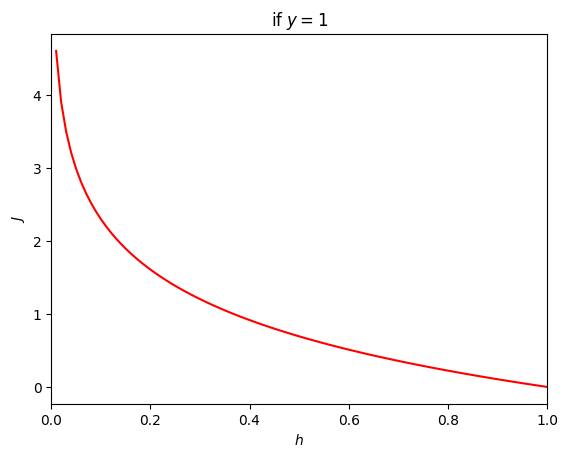

In [8]:
fig = plt.figure()
plt.title("if $y = 1$")
xvals = np.linspace(0.01, 1, 99)
plt.plot(xvals, [-log(xval) for xval in xvals], color = "red")
plt.xlabel("$h$")
plt.xlim(0, 1)
plt.ylabel("$J$")
plt.show()

<h2>The Loss Function, continued</h2>
<ul>
    <li>Consider a single training example $\v{x}$ whose actual class $y = 0$.
    <li>We want $h_{\v{\beta}}(\v{x})$ to be low.
        <ul>
            <li>Why?</li>
        </ul>
    </li>
    <li>So $-\log(1- (h_{\v{\beta}}(\v{x})))$ is a useful loss function.
        <ul>
            <li>Why?</li>
        </ul>
    </li>
</ul>   

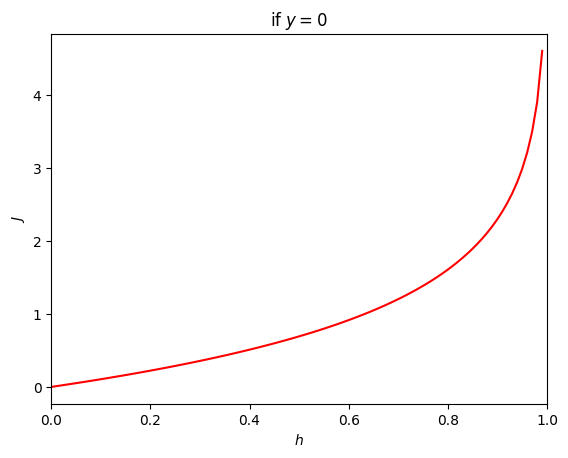

In [9]:
fig = plt.figure()
plt.title("if $y = 0$")
plt.xlabel("$h$")
plt.xlim(0, 1)
plt.ylabel("$J$")
xvals = np.linspace(0, 0.99, 99)
plt.plot(xvals, [-log(1 - xval) for xval in xvals], color = "red")
plt.show()

<h2>The Loss Function, continued</h2>
<ul>
    <li>In summary, for a given example $\v{x}$, we propose the following as the loss function
        $$\left\{ \begin{array}{rl}
                  -\log(h_{\v{\beta}}(\v{x})) & \mbox{if } y = 1 \\
                  -\log(1-h_{\v{\beta}}(\v{x})) & \mbox{if } y = 0
                  \end{array}
          \right.
        $$
        Or, equivalently:
        $$-y\log(h_{\v{\beta}}(\v{x})) + -(1 - y)\log(1-h_{\v{\beta}}(\v{x}))$$
        Or
        $$-[y\log(h_{\v{\beta}}(\v{x})) + (1 - y)\log(1-h_{\v{\beta}}(\v{x}))]$$
    </li>
    <li>The overall loss function, $J$, is simply the average of this over all the training examples:
        $$J(\v{X}, \v{y}, \v{\beta}) = - \frac{1}{m}\sum_{i=1}^m[\v{y}^{(i)}\log(h_{\v{\beta}}(\v{x}^{(i)})) +
                                                (1 - \v{y}^{(i)})\log(1 - h_{\v{\beta}}(\v{x}^{(i)}))]$$
    </li>
    <li>This loss function is sometimes called the <b>log loss</b> fuction, or the <b>binary cross-entropy</b>
        function.
    </li>
</ul>

<h1>Gradient Descent</h1>
<ul>
    <li>So how do we find the hypothesis that minimizes this log loss function?
        <ul>
            <li>Happily, this function is convex.</li>
            <li>But there is no equivalent to the Normal Equation, so we <em>must</em> use Gradient Descent.</li>
            <li>Not that it matters, but here is the partial derivative of its loss function with respect 
                to $\v{\beta}_j$
                $$\frac{\partial J}{\partial\v{\beta}_j} =
                  \frac{1}{m}\sum_{i=1}^m(\v{x}^{(i)})\v{\beta}_j - \v{y}^{(i)}) \times \v{x}_j^{(i)}$$
            </li>
            <li>Since we'll be using Gradient Descent, we must remember to scale our data.</li>
        </ul>
    </li>
</ul>

<h2>Logistic Regression in scikit-learn</h2>
<ul>
    <li>If you want fine-grained control over the learning rate and so on, then scikit-learn offers
        you the <code>SGDClassifier</code> class.
    </li>
    <li>But most people use the <code>LogisticRegression</code> class, which sits on top of the
        <code>SGDClassifier</code> class.
    </li>
    <li>If you want to use <b>regularization</b> with Logistic Regression, then there is a separate 
        scikit-learn class for ridge regression (<code>RidgeClassifier</code>) but none for lasso. But you can
        instead use <code>LogisticRegression</code>, which has an argument called
        <code>penalty</code>, whose possible values include <code>"l1"</code> and <code>"l2"</code>.
        The amount of regularization is usually controlled by a hyperparameter called $\lambda$
        but called <code>alpha</code> in the <code>Lasso</code> and <code>Ridge</code> classes. For
        <code>LogisticRegression</code>, this hyperparameter is called <code>C</code> and
        <code>C</code> is the inverse of <code>alpha</code>, so small values mean more regularization!
    </li>
</ul>

<h1>Multiclass Logistic Regression</h1>
<ul>
    <li>Suppose there are more than two classes.</li>
    <li>There are three solutions:
        <ul>
            <li>One-versus-Rest</li>
            <li>One-versus-One</li>
            <li>Multinomial Logistic Regression</li>
        </ul>
    </li>
</ul>

<h2>One-versus-Rest</h2>
<ul>
    <li><b>One-versus-Rest</b> (also called 'one-versus-all')
        involves training $|C|$ binary classifiers, one per class:
        <ul style="background-color: lightgrey">
            <li>
                <b>for each</b> class $c \in C$
                <ul>
                    <li>
                        create a copy of the training set in which you replace examples 
                        $\Tuple{\v{x}, c}$ by $\Tuple{\v{x}, 1}$ and examples $\Tuple{\v{x}, c'}$ 
                        where $c' \neq c$ by $\Tuple{\v{x}, 0}$
                    </li>
                    <li>
                        train a binary classifier $h^c$ on this modified training set
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>After all these classifiers have been trained, to classify $\v{x}$, we run all the classifiers 
        $h^c$ for each $c \in C$.
        <ul>
            The predicted class of $\v{x}$ is the class $c$ whose classifier $h^c$ predicts 1 with 
            highest probability.
        </ul>
    </li>
    <li>How many classifiers would we end up building for a dataset where there are three classes?</li>
    <li>Do you think kNN needs to use one-versus-rest, or do you think it can already handle
        multi-class classification?
    </li>
</ul>

<h2>One-versus-One</h2>
<ul>
    <li>In <b>One-versus-One</b> (also called 'pairwise classification'), 
        we build a classifier <em>for every pair</em> of classes using 
        only the training data for those two classes.
    </li>
    <li>After all these classifiers have been trained, when we want to classify $\v{x}$, we run all 
        the classifiers and, for each class $c \in C$, we count how many of the classifiers predict 
        that class.
        <ul>
            <li>The predicted class of $\v{x}$ is the one that is predicted most often.
            </li>
        </ul>
    </li>
    <li>One-versus-One's advantage over One-versus-Rest is that the individual classifiers do not need 
        to be classifiers that produce probabilities.
    </li>
    <li>Its disadvantage is the number of individual classifiers it must train:
        <ul>
            <li>How many for a dataset that has three classes?</li>
            <li>In terms of $|C|$, how many in general?</li>
            <li>What offsets this, so that in practice it may be 
                quite feasible?
            </li>
        </ul>
    </li>
</ul>

<h2>Multinomial Logistic Regression</h2>
<ul>
    <li>Logistic Regression is one of the few classifiers that can directly handle <b>multiclass
        classification</b>.
    </li>
    <li>We must modify how the classifier works and the loss function for training. Some of the details are in the Appendix.</li>
</ul>

<h2>Multiclass Logistic Regression in scikit-learn</h2>
<ul>
    <li>The short story is: you don't have to worry. If there are more than two classes, scikit-learn will handle them without you needing to do anything.</li>
    <li>What will it do?
        <ul>
            <li>For most of scikit-learn's binary classifiers, it will use one-versus-rest.</li>
            <li>In the case of of scikit-learn's <code>LogisticRegression</code> class, it will use Multinomial Logistic Regression &mdash; the method explained in the Appendix.</li>
        </ul>
    </li>
    <li>There are also classes <code>OneVsRestClassifier</code> and <code>OneVsOneClassifier</code>.
    </li>
</ul>

<h2>Which is better?</h2>
<ul>
    <li>Sometimes, even when you have a classifier, such as Logistic Regression, that can directly 
        handle multiclass classification, using it in a One-versus-One fashion can be more accurate! 
        (Have you any ideas why?)
    </li>
    <li>But one-versus-rest and one-versus-one have higher training costs.</li>
</ul>

<h1>Appendix</h1>
<h2>Multinomial Logistic Regression</h2>
<ul>
    <li>We can modify Logistic Regression so that it can directly handle <b>multiclass
        classification</b>.
    </li>
    <li>We must modify how the classifier works and the loss function for training.
    </li>
</ul>

<h3>Class-specific coefficients</h3>
<ul>
    <li>Now, instead of one vector of coefficients, $\v{\beta}$, the classifier has one <em>per class</em>,
        $\v{\beta}_c$  for each $c \in C$.
    </li>
    <li>Hence, instead of computing one value, $\v{x}{\v{\beta}}$, it computes one per class,
        $\v{x}\v{\beta}_c$ for each $c \in C$.
    </li>
    <li>Now, 'squashing' is more complicated:
        <ul>
            <li>Not only must each of these values be squashed to $[0,1]$;</li>
            <li>but they must also sum to 1.</li>
        </ul>
        So we do not use the sigmoid function.
    </li>
    <li>We use the <b>softmax function</b> (but still often designated by $\sigma$):
        $$Prob(\hat{y} = c\, |\, \v{x}) = \sigma(\v{x}\v{\beta}_c) = \frac{e^{\v{x}\v{\beta}_c}}{\sum_{c' \in C} e^{\v{x}\v{\beta}_{c'}}}$$
    </li>
    <li>(BTW, if we put all the different $\v{\beta}_c$ into a single matrix $\v{B}$,
        then we can have a vectorized implementation  of this.)
    </li>
    <li>Finally, there is no thresholding this time: the classifier simply predicts the class with the
        highest estimated probability.
    </li>
    <li>If you like symbols, here it is all in one line:
        $$\hat{y} = \argmax_{c \in C}(\sigma(\v{x}\v{\beta}_c))$$
    </li>
    <li>(A saving: To work out the probabilities, you need the softmax formula given above. But if all you want to know is the winner, then all you need is $\argmax_{c \in C}(\v{x}\v{\beta}_c)$ because the rest of the softmax formula makes no difference to the ordering.)</li>
</ul>

<h3>Loss Function</h3>
<ul>
    <li>So how does logistic regression learn all these different $\v{\beta}_c$?</li>
    <li>We need a new loss function: the <b>cross-entropy loss function</b> (or sometimes
        the <b>categorical cross-entropy function</b>):
        $$J(\v{X}, \v{y}, \v{B}) = -\frac{1}{m}\sum_{i=1}^m\sum_{c \in C}I(\v{y}^{(i)} = c)\log(\sigma(\v{x}^{(i)}\v{\beta}_c))$$
        where $I(p)$ is the indicator function that outputs 1 if predicate $p$ is true and zero otherwise.
     </li>
     <li>The easiest way to get some grasp of this is to realise that when there are just two classes, it is
         equivalent to the loss function we used earlier.
    </li>
</ul>